In [ ]:
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_single_file(
    "https://huggingface.co/stabilityai/stable-audio-open-1.0/blob/main/vae/diffusion_pytorch_model.safetensors"
)

In [ ]:
import torch
import soundfile as sf
from diffusers import StableAudioPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableAudioPipeline.from_pretrained("stabilityai/stable-audio-open-1.0", torch_dtype=torch.float16)
pipe = pipe.to(device)

# define the prompts
prompt = "The sound of a hammer hitting a wooden surface."
negative_prompt = "Low quality."

# set the seed for generator
generator = torch.Generator().manual_seed(0)

# run the generation
audio = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=200,
    audio_end_in_s=10.0,
    num_waveforms_per_prompt=3,
    generator=generator,
).audios

output = audio[0].T.float().cpu().numpy()
sf.write("hammer.wav", output, pipe.vae.sampling_rate)


In [13]:
import torch
from archisound import ArchiSound

autoencoder = ArchiSound.from_pretrained("dmae1d-ATC32-v3")
import numpy as np
def generate_sine_wave(freq, sample_rate, duration, channels=2):
    """
    Generates a sine wave of a given frequency and duration.

    Args:
        freq (float): Frequency of the sine wave in Hz.
        sample_rate (int): Sample rate in Hz.
        duration (float): Duration of the wave in seconds.
        channels (int): Number of audio channels (1 for mono, 2 for stereo).
    Returns:
        torch.Tensor: A tensor of shape [1, channels, num_samples].
    """
    t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)
    wave = np.sin(2 * np.pi * freq * t)
    if channels > 1:
        wave = np.stack([wave] * channels)  # Duplicate wave for each channel
    return torch.tensor(wave).unsqueeze(0)  # Add batch dimension

# Parameters
frequency = 440  # A4 note (440 Hz)
sample_rate = 44100  # CD-quality audio
duration = 2**18 / sample_rate  # Duration to match the length of x

x = generate_sine_wave(frequency, sample_rate, duration).float()  # [1, 2, 2**18]
z = autoencoder.encode(x) # [1, 32, 512]
y = autoencoder.decode(z, num_steps=20) # [1, 2, 262144]

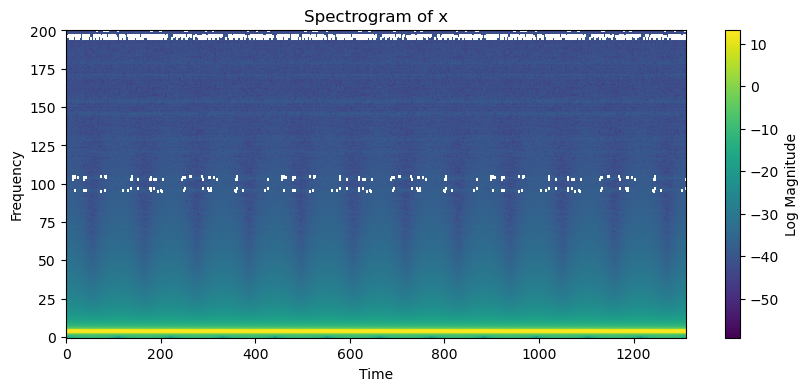

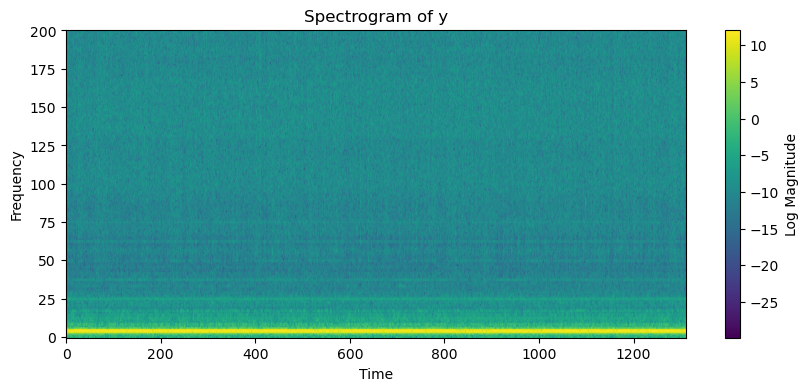

In [14]:
import torchaudio
import matplotlib.pyplot as plt
def plot_spectrogram(audio, title, sr=22050):
    """Plots spectrogram of a given audio tensor."""

    audio = audio.squeeze().numpy()
    
    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram()(torch.tensor(audio))
    
    plt.figure(figsize=(10, 4))
    plt.imshow(spectrogram.log2().numpy(), aspect='auto', origin='lower', cmap='viridis')
    plt.title(title)
    plt.colorbar(label='Log Magnitude')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

# Plot spectrograms
plot_spectrogram(x[0][0], "Spectrogram of x")
plot_spectrogram(y[0][0], "Spectrogram of y")